<a href="https://colab.research.google.com/github/appliedecon/tidyTuesday/blob/main/tidy_tuesday_departures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://github.com/rfordatascience/tidytuesday/tree/master/data/2021/2021-04-27

Tiny bit of data wrangling, simple OLS trend regression, bootstrapping.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-27/departures.csv')

print(f'Rows: {df.shape[0]}\nColumns: {df.shape[1]}')

Rows: 9423
Columns: 19


In [2]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dismissal_dataset_id,9423,NaN,NaN,NaN,5684.1,25005.5,1,2305.5,4593,6812.5,559044
coname,9423,3860,SEARS HOLDINGS CORP,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gvkey,9423,NaN,NaN,NaN,40132.5,53921.3,1004,7337,14385,60900.5,328795
fyear,9423,NaN,NaN,NaN,2007.74,8.18815,1987,2000,2008,2016,2020
co_per_rol,9423,NaN,NaN,NaN,25580.2,18202.4,-1,8555.5,22980,39275.5,64602
exec_fullname,9423,8701,Mark Vincent Hurd,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
departure_code,7756,NaN,NaN,NaN,5.19572,1.52668,1,5,5,7,9
ceo_dismissal,7610,NaN,NaN,NaN,0.195664,0.396737,0,0,0,0,1
interim_coceo,318,6,Interim,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure_no_ceodb,9423,NaN,NaN,NaN,1.02632,0.166587,0,1,1,1,3


In [3]:
departureReference = {1:'Involuntary - CEO Death',
                      2:'Involuntary - CEO Illness',
                      3:'Involuntary - Poor Performance',
                      4:'Involuntary - Legal Concerns',
                      5:'Voluntary - Retired',
                      6:'Voluntary - Took New Job',
                      7:'Other',
                      8:'Missing',
                      9:'Error'
}

df['departure_code'] = np.where(df['departure_code'].isna(), 8, df['departure_code'])
df['departure_desc'] = df['departure_code'].map(departureReference)

df['departure_desc'].value_counts(dropna=False)

Voluntary - Retired               3598
Other                             2133
Missing                           1720
Involuntary - Poor Performance    1320
Involuntary - Legal Concerns       195
Voluntary - Took New Job           183
Involuntary - CEO Illness           97
Error                               93
Involuntary - CEO Death             84
Name: departure_desc, dtype: int64

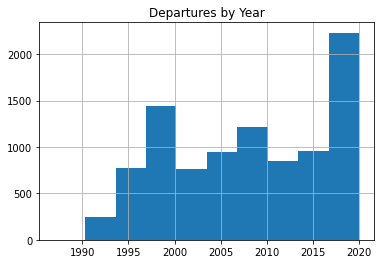

In [4]:
df.fyear.hist()
plt.title('Departures by Year')
plt.show()

What about the rise of involuntary departures?

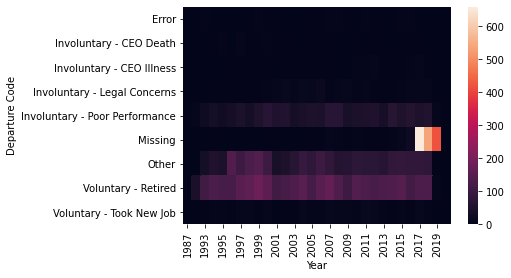

In [5]:
sns.heatmap(df.pivot_table(columns='fyear', index='departure_desc', aggfunc='count', values='dismissal_dataset_id', dropna=False, fill_value=0))
plt.xlabel('Year')
plt.ylabel('Departure Code')
plt.show()

Looks like NAs/missings were virtually non-existent and then exploded. Signals the recent data is not complete. Remove.

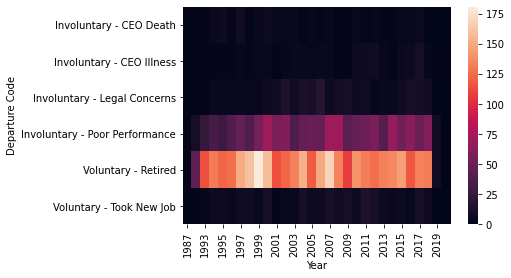

In [6]:
involuntary = [1,2,3,4]
excludedCd = [7,8,9]

df['involuntary'] = df['departure_code'].isin(involuntary)
df['excludedCodes'] = df['departure_code'].isin(excludedCd)

sns.heatmap(df.query('~excludedCodes').pivot_table(columns='fyear', index='departure_desc', aggfunc='count', values='dismissal_dataset_id', dropna=False, fill_value=0))
plt.xlabel('Year')
plt.ylabel('Departure Code')
plt.show()

Looks like the main departure reasons are consistently voluntary retirement (makes sense) and involuntary departure (i.e., "you're fired!") for poor performance.

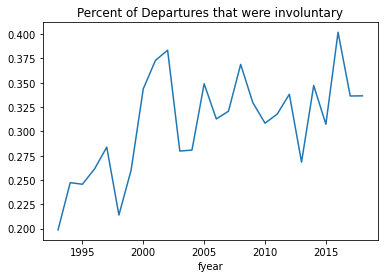

In [7]:
involuntaryTrend = df.query('fyear>= 1993 and fyear <= 2018 and ~excludedCodes',engine='python').groupby('fyear')['involuntary'].mean()
involuntaryTrend.plot()
plt.title('Percent of Departures that were involuntary')
plt.show()

### Seems to be an increase in naughty CEOs. Can we model the trend?

In [8]:
import statsmodels.api as sm

timeTrend = range(0, len(involuntaryTrend))
timeTrend = pd.Series(timeTrend, index=involuntaryTrend.index)

# statsmodels doesn't include the constant, so remember to explicitly add it.
timeTrend = sm.add_constant(timeTrend)

mod = sm.OLS(involuntaryTrend, timeTrend)

results = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


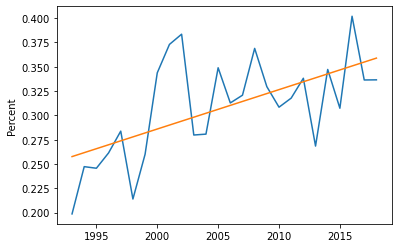

In [9]:
involuntaryTrend.plot()
pd.Series(results.predict(), index=involuntaryTrend.index).plot()
plt.xlabel('')
plt.ylabel('Percent')
plt.show()

Hmm... looks like the data suggests there is an increasing trend in involuntary departures. More scrutiny now?

### Now estimate what the annual change in the rate is from the data. We have the simple linear trend, but try a bootstrapped GLM to estimate.

In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            involuntary   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     13.47
Date:                Sun, 02 May 2021   Prob (F-statistic):            0.00121
Time:                        19:44:54   Log-Likelihood:                 46.435
No. Observations:                  26   AIC:                            -88.87
Df Residuals:                      24   BIC:                            -86.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2576      0.016     16.007      0.000       0.224       0.291
0              0.0041      0.001      3.670      0.001       0.002       0.006
==============================================================================
Omnibus:                        1.563   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.177
Skew:                           0.510   Prob(JB):                        0.555
Kurtosis:                       2.784   Cond. No.                         28.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OLS regression suggests about 40 basis points a year increase. It will be interesting to see what the bootstrapped difference using GLM might be...

In [38]:
### using statsmodel.api
dataForBoot = df.copy()
dataForBoot = dataForBoot.query('~excludedCodes and fyear >= 1993 and fyear <= 2018')
dataForBoot = dataForBoot.assign(y = np.where(dataForBoot['involuntary'] == True, 1, 0), X = dataForBoot['fyear'])
dataForBoot = dataForBoot[['y', 'X']]
dataForBoot = dataForBoot.reset_index()

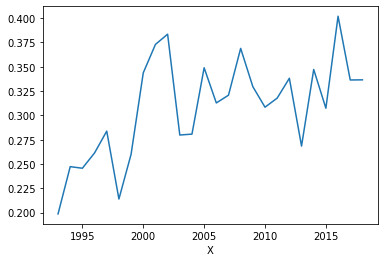

In [41]:
dataForBoot.groupby('X')['y'].mean().plot()
plt.show()

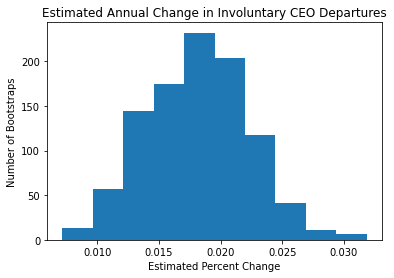

In [86]:
def logReg(df):
  glm_binom = sm.GLM(df.y, sm.add_constant(df.X, prepend=False), family=sm.families.Binomial())
  res = glm_binom.fit()
  return np.exp(res.params[0]) - 1

def boot(df, splits=1000, size_per_split=0.50):
  import random
  '''
  splits = number of samples to be run through the model
  size_per_split = percent of the dataset to be sampled for each split
  '''
  coef = list()

  for _ in range(splits):
    indexSample = random.sample(df.index.to_list(), k=int(df.shape[0]*size_per_split))
    indexSample = list(set(indexSample))
    coef.append(logReg(df.iloc[indexSample, :]))
  
  return coef

estimates = boot(dataForBoot)

plt.hist(estimates)
plt.xlabel('Estimated Percent Change')
plt.ylabel('Number of Bootstraps')
plt.title('Estimated Annual Change in Involuntary CEO Departures')
plt.show()

This suggests that the rate of involuntary departures increases between 1.0 - 2.5% per year. That's a bit higher than the simple trend model would suggest.